In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
gbg_all_2023 = pd.read_excel("./data/final_gbg_rr.xlsx")
gbg_all_2022 = pd.read_excel("./data/final_gbg_rr_2022.xlsx")

In [3]:
# let's filter out playoffs, this will mess with active vs inactive players
gbg_all_2022 = gbg_all_2022[gbg_all_2022['week'] < 18]

In [4]:
gbg_all_2022['week_total'] = gbg_all_2022['week']
gbg_all_2023['week_total'] = gbg_all_2023['week'] + 17

In [76]:
gbg_all = pd.concat([gbg_all_2022, gbg_all_2023])

In [77]:
gbg_all.sort_values(by=['player_id', 'week_total'])

,player_id,game_id,week,position,player_name,team,fpoints,receiving_yards,avg_yac,avg_depth_of_target,...,age,draft_year,draft_round,draft_pick,draft_ovr,twitter_username,height,weight,college,week_total
4198,00-0019596,2022_01_TB_DAL,1,QB,Tom Brady,TB,0.0,0.0,0.00,0.000000,...,46.3,2000.0,6.0,33.0,199.0,NaN,76.0,225.0,Michigan,1
4157,00-0019596,2022_02_TB_NO,2,QB,Tom Brady,TB,0.0,0.0,0.00,0.000000,...,46.3,2000.0,6.0,33.0,199.0,NaN,76.0,225.0,Michigan,2
4192,00-0019596,2022_03_GB_TB,3,QB,Tom Brady,TB,0.0,0.0,0.00,0.000000,...,46.3,2000.0,6.0,33.0,199.0,NaN,76.0,225.0,Michigan,3
4149,00-0019596,2022_04_KC_TB,4,QB,Tom Brady,TB,0.0,0.0,0.00,0.000000,...,46.3,2000.0,6.0,33.0,199.0,NaN,76.0,225.0,Michigan,4
4164,00-0019596,2022_05_ATL_TB,5,QB,Tom Brady,TB,0.0,0.0,0.00,0.000000,...,46.3,2000.0,6.0,33.0,199.0,NaN,76.0,225.0,Michigan,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,00-0039165,2023_08_CLE_SEA,8,RB,Zach Charbonnet,SEA,8.4,11.0,7.50,-2.000000,...,22.9,2023.0,2.0,21.0,52.0,NaN,73.0,214.0,UCLA,25
5087,00-0039165,2023_09_SEA_BAL,9,RB,Zach Charbonnet,SEA,2.3,5.0,5.00,0.000000,...,22.9,2023.0,2.0,21.0,52.0,NaN,73.0,214.0,UCLA,26
5088,00-0039165,2023_10_WAS_SEA,10,RB,Zach Charbonnet,SEA,10.2,18.0,4.50,-0.200000,...,22.9,2023.0,2.0,21.0,52.0,NaN,73.0,214.0,UCLA,27
5089,00-0039165,2023_11_SEA_LA,11,RB,Zach Charbonnet,SEA,12.9,22.0,6.50,-2.833333,...,22.9,2023.0,2.0,21.0,52.0,NaN,73.0,214.0,UCLA,28


In [78]:
# limiting ourself to receivers, running backs, tighht ends
gbg_skill = gbg_all[gbg_all.position.isin(['WR', 'RB', 'TE'])]

In [79]:
rushing_stats = [
    'rushing_yards',
    'avg_ypc',
    'carries',
    'rushing_touchdowns',
    'opps_1',
    'opps_2',
    'opps_3',
    'opps_4',
    'total_opps',
    'rz_opps',
    'rushing_fpoints',
    'rushing_fumbles',
    'rushing_fumbles_lost',
    'rushing_yards_before_contact',
    'rushing_yards_before_contact_avg',
    'rushing_yards_after_contact',
    'rushing_yards_after_contact_avg',
    'rushing_broken_tackles',
    'efficiency',
    'percent_attempts_gte_eight_defenders',
    'avg_time_to_los',
    'expected_rush_yards',
    'rush_yards_over_expected',
    'rush_yards_over_expected_per_att',
    'rush_pct_over_expected'
]

rec_stats = [
    'receiving_yards',
    'avg_yac',
    'avg_depth_of_target',
    'receptions',
    'max_target_depth',
    'receiving_touchdowns',
    'air_yards',
    'unrealized_air_yards',
    'targets_1',
    'targets_2',
    'targets_3',
    'targets_4',
    'total_targets',
    'rz_targets',
    'receiving_fpoints',
    'receiving_fumbles',
    'receiving_fumbles_lost',
    'receiving_first_downs',
    'receiving_epa',
    'receiving_2pt_conversions',
    'racr',
    'target_share',
    'air_yards_share',
    'wopr',
    'receiving_broken_tackles',
    'receiving_drop',
    'receiving_drop_pct',
    'receiving_int',
    'receiving_rat',
    'avg_cushion',
    'avg_separation'
]

### Cleaning
Let's clean our data a bit and add some new features.
In my first models, there won't be any time-series behavior. Each training entry will have a 
1. target (fantasy points)
2. Average for most stats already in datasets from all previous weeks.
3. Other injured starter one-hot variable (is there another injured starter at any other skill position? DEPTH = 1,2)
4. depth!!! - this encodes "did the starter get injured?"
5. One-hot position
6. Avg. Defensive fantasy points allowed to position.
7. Associated QBR.
8. Is new quarterback?
7. num Injured Defensive starters?




In [80]:
# let's drop some columns we won't be using
# dopes it make sense to keep garbage time fantasy points?
temp = gbg_skill.drop(
    [
        "player_name",
        "team",
        "birthdate",
        "draft_round",
        "draft_pick",
        "draft_year",
        "draft_ovr",
        "twitter_username",
        "college",
        "rush_touchdowns"
    ],
    axis=1,
).copy()


In [81]:
temp[rushing_stats].isna().sum()/len(temp)

rushing_yards                           0.084935
avg_ypc                                 0.084935
carries                                 0.084935
rushing_touchdowns                      0.084935
opps_1                                  0.084935
opps_2                                  0.084935
opps_3                                  0.084935
opps_4                                  0.084935
total_opps                              0.084935
rz_opps                                 0.084935
rushing_fpoints                         0.084935
rushing_fumbles                         0.180570
rushing_fumbles_lost                    0.180570
rushing_yards_before_contact            0.773980
rushing_yards_before_contact_avg        0.774169
rushing_yards_after_contact             0.773980
rushing_yards_after_contact_avg         0.774169
rushing_broken_tackles                  0.773980
efficiency                              0.922829
percent_attempts_gte_eight_defenders    0.922829
avg_time_to_los     

In [82]:
a = temp[rec_stats].isna().sum()/len(temp)
a[a>0]

target_share                0.002557
air_yards_share             0.002557
wopr                        0.002557
receiving_broken_tackles    0.380835
receiving_drop              0.380835
receiving_drop_pct          0.380835
receiving_int               0.380835
receiving_rat               0.380835
avg_cushion                 0.808730
avg_separation              0.808730
dtype: float64

In [83]:
# let's fill some NaN's
# fill rushing stats for players with no opportunities
filt_opps = (temp["total_opps"].isna()) | (temp["total_opps"] == 0)
temp.loc[filt_opps, rushing_stats] = temp.loc[filt_opps, rushing_stats].fillna(0)
# fill receiving stats for players with no targets
filt_targ = (temp["total_targets"].isna()) | (temp["total_targets"] == 0)
temp.loc[filt_targ, rec_stats] = temp.loc[filt_targ, rec_stats].fillna(0)


# how to fill?
# receiving_rat
# depth we will fill with mode
# why isn't this working?
temp["depth_team"] = temp.groupby("player_id")["depth_team"].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) > 0 else x.fillna(np.nan)
)
# the rest of these players are low on the depth chart so let's just fill with the max
temp["depth_team"] = temp["depth_team"].fillna(temp.depth_team.max())

# average fill
# filling players acg cushion and separation with their season long average
temp["avg_cushion"] = temp.groupby("player_id")["avg_cushion"].transform(
    lambda x: x.fillna(x.mean())
)
temp["avg_separation"] = temp.groupby("player_id")["avg_separation"].transform(
    lambda x: x.fillna(x.mean())
)
temp["rushing_yards_before_contact"] = temp.groupby("player_id")[
    "rushing_yards_before_contact"
].transform(lambda x: x.fillna(x.mean()))
temp["rushing_yards_before_contact_avg"] = temp.groupby("player_id")[
    "rushing_yards_before_contact_avg"
].transform(lambda x: x.fillna(x.mean()))
temp["rushing_yards_after_contact"] = temp.groupby("player_id")[
    "rushing_yards_after_contact"
].transform(lambda x: x.fillna(x.mean()))
temp["rushing_yards_after_contact_avg"] = temp.groupby("player_id")[
    "rushing_yards_after_contact_avg"
].transform(lambda x: x.fillna(x.mean()))
temp["efficiency"] = temp.groupby("player_id")["efficiency"].transform(
    lambda x: x.fillna(x.mean())
)
temp["percent_attempts_gte_eight_defenders"] = temp.groupby("player_id")[
    "percent_attempts_gte_eight_defenders"
].transform(lambda x: x.fillna(x.mean()))
temp["avg_time_to_los"] = temp.groupby("player_id")["avg_time_to_los"].transform(
    lambda x: x.fillna(x.mean())
)
temp["expected_rush_yards"] = temp.groupby("player_id")[
    "expected_rush_yards"
].transform(lambda x: x.fillna(x.mean()))
temp["rush_yards_over_expected"] = temp.groupby("player_id")[
    "rush_yards_over_expected"
].transform(lambda x: x.fillna(x.mean()))
temp["rush_yards_over_expected_per_att"] = temp.groupby("player_id")[
    "rush_yards_over_expected_per_att"
].transform(lambda x: x.fillna(x.mean()))
temp["rush_pct_over_expected"] = temp.groupby("player_id")[
    "rush_pct_over_expected"
].transform(lambda x: x.fillna(x.mean()))
temp["receiving_rat"] = temp.groupby("player_id")["receiving_rat"].transform(
    lambda x: x.fillna(x.mean())
)
# now fill the rest with the global mean
# TODO: May want to switch some of these to median depending on distributions
avg_sep_mean = temp[temp["total_targets"] > 0]["avg_separation"].mean()
avg_cush_mean = temp[temp["total_targets"] > 0]["avg_cushion"].mean()
eff_mean = temp[temp["total_opps"] > 0]["efficiency"].mean()
pc_att_8_mean = temp[temp["total_opps"] > 0][
    "percent_attempts_gte_eight_defenders"
].mean()
av_t_los_mean = temp[temp["total_opps"] > 0]["avg_time_to_los"].mean()
exp_rush_mean = temp[temp["total_opps"] > 0]["expected_rush_yards"].mean()
rush_ovr_exp_mean = temp[temp["total_opps"] > 0]["rush_yards_over_expected"].mean()
rush_ovr_exp_att_mean = temp[temp["total_opps"] > 0][
    "rush_yards_over_expected_per_att"
].mean()
pct_rush_ovr_mean = temp[temp["total_opps"] > 0]["rush_pct_over_expected"].mean()
rec_rat_mean = temp[temp["total_targets"] > 0]["receiving_rat"].mean()

temp["avg_cushion"] = temp["avg_cushion"].fillna(avg_cush_mean)
temp["avg_separation"] = temp["avg_separation"].fillna(avg_sep_mean)
temp["age"] = temp["age"].fillna(temp.age.mean())
temp["height"] = temp["height"].fillna(temp.height.mean())
temp["weight"] = temp["weight"].fillna(temp.weight.mean())
temp["efficiency"] = temp["efficiency"].fillna(eff_mean)
temp["percent_attempts_gte_eight_defenders"] = temp[
    "percent_attempts_gte_eight_defenders"
].fillna(pc_att_8_mean)
temp["avg_time_to_los"] = temp["avg_time_to_los"].fillna(av_t_los_mean)
temp["expected_rush_yards"] = temp["expected_rush_yards"].fillna(exp_rush_mean)
temp["rush_yards_over_expected"] = temp["rush_yards_over_expected"].fillna(
    rush_ovr_exp_mean
)
temp["rush_yards_over_expected_per_att"] = temp[
    "rush_yards_over_expected_per_att"
].fillna(rush_ovr_exp_att_mean)
temp["rush_pct_over_expected"] = temp["rush_pct_over_expected"].fillna(
    pct_rush_ovr_mean
)
temp["receiving_rat"] = temp["receiving_rat"].fillna(rec_rat_mean)
temp["rushing_yards_before_contact"] = temp["rushing_yards_before_contact"].fillna(
    temp[temp["total_opps"] > 0]["rushing_yards_before_contact"].mean()
)
temp["rushing_yards_before_contact_avg"] = temp[
    "rushing_yards_before_contact_avg"
].fillna(temp[temp["total_opps"] > 0]["rushing_yards_before_contact_avg"].mean())
temp["rushing_yards_after_contact"] = temp["rushing_yards_after_contact"].fillna(
    temp[temp["total_opps"] > 0]["rushing_yards_after_contact"].mean()
)
temp["rushing_yards_after_contact_avg"] = temp[
    "rushing_yards_after_contact_avg"
].fillna(temp[temp["total_opps"] > 0]["rushing_yards_after_contact_avg"].mean())


# most others can be filled with 0
temp["snap_percentage_1"] = temp["snap_percentage_1"].fillna(0)
temp["snap_percentage_2"] = temp["snap_percentage_2"].fillna(0)
temp["snap_percentage_3"] = temp["snap_percentage_3"].fillna(0)
temp["snap_percentage_4"] = temp["snap_percentage_4"].fillna(0)
temp["receiving_broken_tackles"] = temp["receiving_broken_tackles"].fillna(0)
temp["receiving_drop"] = temp["receiving_drop"].fillna(0)
temp["receiving_drop_pct"] = temp["receiving_drop_pct"].fillna(0)
temp["receiving_int"] = temp["receiving_int"].fillna(0)
temp["rushing_broken_tackles"] = temp["rushing_broken_tackles"].fillna(0)
temp["snap_percentage_1"] = temp["snap_percentage_1"].fillna(0)
temp["snap_percentage_2"] = temp["snap_percentage_2"].fillna(0)
temp["snap_percentage_3"] = temp["snap_percentage_3"].fillna(0)
# may need to drop high-nan vars like efficiency where it doesn't make much sense to fill them with 0?

# if you're a wide reciever and you have nulls in rushing stats, fill them with 0, and visa versa

# # let's one-hot the position column
# X = pd.get_dummies(X, columns=['position'])

temp.drop('receiving_2pt_conversions', axis=1, inplace=True)

In [84]:
temp.replace([np.inf, -np.inf], 0, inplace=True)

In [85]:
a = temp.isna().sum()/len(temp)
a[a>0].sort_values(ascending=False)

Series([], dtype: float64)

### Some notes

What I want to add: 
1. QB related features
2. injury features
3. defensive matchup features
4. rushing opportunity share


But let's move forward for now.

In [11]:
temp.columns

Index(['player_id', 'game_id', 'week', 'position', 'fpoints',
       'receiving_yards', 'avg_yac', 'avg_depth_of_target', 'receptions',
       'air_yards', 'unrealized_air_yards', 'max_target_depth',
       'receiving_touchdowns', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'receiving_fpoints',
       'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
       'total_relevant_snaps', 'snap_percentage_1', 'snap_percentage_2',
       'snap_percentage_3', 'snap_percentage_4', 'receiving_fumbles',
       'receiving_fumbles_lost', 'receiving_first_downs', 'receiving_epa',
       'racr', 'target_share', 'air_yards_share', 'wopr',
       'receiving_broken_tackles', 'receiving_drop', 'receiving_drop_pct',
       'receiving_int', 'receiving_rat', 'avg_cushion', 'avg_separation',
       'depth_team', 'rushing_yards', 'avg_ypc', 'carries',
       'rushing_touchdowns', 'opps_1', 'opps_2', 'opps_3', 'opps_4',
       'total_opps', 'rz_opps', '

<Axes: xlabel='fpoints', ylabel='Count'>

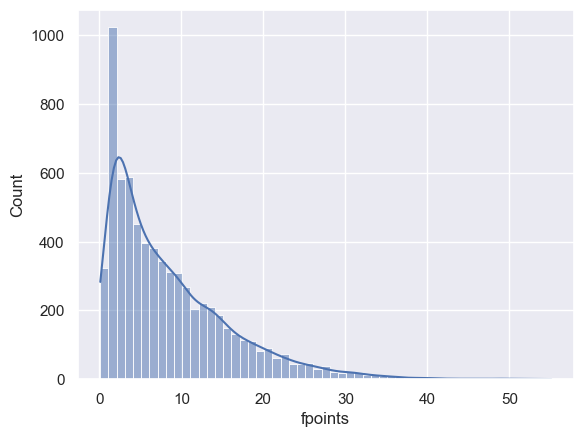

In [86]:
# should we thin out some of the lower fantasy performances?
sns.histplot(temp[temp['fpoints'] > 0]['fpoints'], kde=True)

In [121]:
# now we need to get the dataset to be averages of all datapoints aside from fantasy points before the current week.
wrs = temp[temp['position'] == 'WR']
new_dataset = wrs[['player_id', 'game_id', 'week', 'week_total', 'position', 'fpoints', 'age', 'height', 'weight', 'depth_team']]
# cmas = temp[['player_id', 'game_id', 'week', 'fpoints',
#        'receiving_yards', 'avg_yac', 'avg_depth_of_target', 'receptions',
#        'air_yards', 'unrealized_air_yards', 'max_target_depth',
#        'receiving_touchdowns', 'targets_1', 'targets_2', 'targets_3',
#        'targets_4', 'total_targets', 'rz_targets', 'receiving_fpoints',
#        'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
#        'total_relevant_snaps', 'snap_percentage_1', 'snap_percentage_2',
#        'snap_percentage_3', 'snap_percentage_4', 'receiving_fumbles',
#        'receiving_fumbles_lost', 'receiving_first_downs', 'receiving_epa',
#         'racr', 'target_share', 'air_yards_share',
#        'wopr', 'receiving_broken_tackles', 'receiving_drop',
#        'receiving_drop_pct', 'receiving_int', 'receiving_rat', 'avg_cushion',
#        'avg_separation', 'rushing_yards', 'avg_ypc', 'carries',
#        'rushing_touchdowns', 'opps_1', 'opps_2', 'opps_3', 'opps_4',
#        'total_opps', 'rz_opps', 'rushing_fpoints', 'rushing_fumbles',
#        'rushing_fumbles_lost', 'rushing_yards_before_contact',
#        'rushing_yards_before_contact_avg', 'rushing_yards_after_contact',
#        'rushing_yards_after_contact_avg', 'rushing_broken_tackles',
#        'efficiency', 'percent_attempts_gte_eight_defenders', 'avg_time_to_los',
#        'expected_rush_yards', 'rush_yards_over_expected',
#        'rush_yards_over_expected_per_att', 'rush_pct_over_expected',
#        'total_garbage_fpoints']].sort_values(by=['player_id', 'week'])
cmas = wrs[['player_id', 'game_id', 'week_total', 'fpoints',
       'receiving_yards', 'avg_yac', 'avg_depth_of_target', 'receptions',
       'air_yards', 'unrealized_air_yards', 'max_target_depth',
       'receiving_touchdowns', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'receiving_fpoints',
       'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
       'total_relevant_snaps', 'snap_percentage_1', 'snap_percentage_2',
       'snap_percentage_3', 'snap_percentage_4', 'receiving_fumbles',
       'receiving_fumbles_lost', 'receiving_first_downs', 'receiving_epa',
        'racr', 'target_share', 'air_yards_share',
       'wopr', 'receiving_broken_tackles', 'receiving_drop',
       'receiving_drop_pct', 'receiving_int', 'receiving_rat', 'avg_cushion',
       'avg_separation', 
       'total_garbage_fpoints']].sort_values(by=['player_id', 'week_total'])
cmas = cmas.set_index(['game_id', 'week_total']).groupby(['player_id']).rolling(2, min_periods=1).mean().reset_index().rename({'fpoints':'past_fpoints'}, axis=1)


In [122]:
# because we want to correlate the average of all past performances with the current 
cmas['week_total'] = cmas['week_total'] + 1

In [123]:
# now we merge
data = new_dataset.merge(cmas.drop('game_id', axis=1), left_on=['player_id', 'week_total'], right_on=['player_id', 'week_total'])
data.head()
# first OnHot position column
# data = pd.get_dummies(data, columns=['position'], dtype=int)
data.drop('position', axis=1, inplace=True)

In [124]:
# now let's scale our data

# scale down week and depth
data["week"] = data["week"] / 17
data["depth_team"] = data["depth_team"] / 3

features_train, features_test, target_train, target_test = train_test_split(data.drop(['fpoints', 'player_id', 'game_id'], axis=1), data['fpoints'], test_size = 0.33, random_state = 42)

In [125]:
# scaling
non_scale_list = [
                    "week",
                    "depth_team",
                    "snap_percentage_1",
                    "snap_percentage_2",
                    "snap_percentage_3",
                    "snap_percentage_4",
                    "target_share",
                    "air_yards_share",
                    "wopr",
                    "receiving_drop_pct",
                    # "rush_pct_over_expected",
                    # "position_RB",
                    # "position_TE",
                    # "position_WR",
                ]
# columns you don't need to scale:
scale_list = [
    x
    for x in data.columns
    if x
    not in non_scale_list + ['player_id', 'game_id', 'fpoints', 'week_total']
]


feature_list = scale_list + non_scale_list

# scale train data
X_train = features_train[scale_list]
leftover_train = np.asarray(
            features_train[non_scale_list]
        )
y_train = np.asarray(target_train)

train_scaler = StandardScaler()
X_train_s = train_scaler.fit_transform(X=X_train)
X_train_s_all = np.concatenate((X_train_s, leftover_train), axis=1)

# scale test data
X_test = features_test[scale_list]
leftover_test = np.asarray(
            features_test[non_scale_list]
        )
y_test = np.asarray(target_test)

test_scaler = StandardScaler()
X_test_s = test_scaler.fit_transform(X=X_test)
X_test_s_all = np.concatenate((X_test_s, leftover_test), axis=1)

In [126]:
print(f"shape1 {X_train_s.shape}, shape2: {X_train_s_all.shape}")

shape1 (2761, 36), shape2: (2761, 46)


### Modeling

A really good [article](https://towardsdatascience.com/7-of-the-most-commonly-used-regression-algorithms-and-how-to-choose-the-right-one-fc3c8890f9e3)

Let's get some models going! We will implement the following after a few test models:
1. cross validation
2. hyperparameter optimization
3. Feature selection

In [127]:
# let's train a simple regression model to see how we do
reg = LinearRegression().fit(X_train_s_all, y_train)
reg.score(X_train_s_all, y_train)

0.40154961846466464

In [128]:
# not super great...
# I think this work is more suited to a random forest...
from sklearn.ensemble import RandomForestRegressor
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    "warm_start":True,
    "oob_score":True,
    "random_state": 42,
}
regressor = RandomForestRegressor(**params)
regressor.fit(X_train_s_all, y_train)

RandomForestRegressor(max_depth=4, min_samples_split=5, oob_score=True,
                      random_state=42, warm_start=True)

In [129]:
y_pred = regressor.predict(X_test_s_all)

In [130]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.3996556623024441

Text(0.5, 0, 'Mean decrease in impurity')

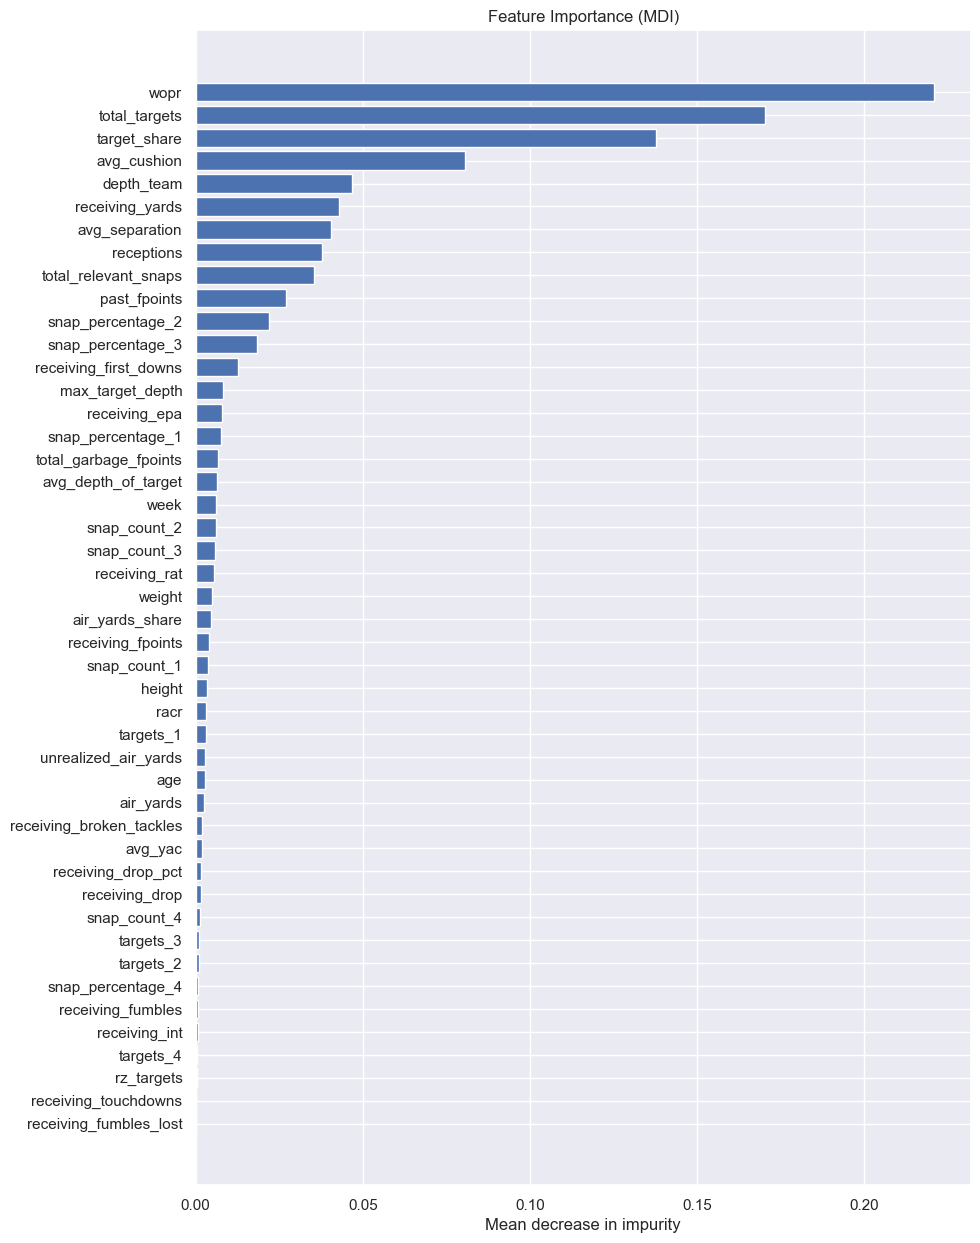

In [131]:
# obtain feature importance
feature_importance = regressor.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
fig,ax = plt.subplots(figsize=(10,15))

ax.barh(pos, feature_importance[sorted_idx], align="center")

ax.set_yticks(pos, np.array(feature_list)[sorted_idx])
ax.set_title("Feature Importance (MDI)")
ax.set_xlabel("Mean decrease in impurity")

In [24]:
from sklearn.svm import SVR
svr_regressor = SVR(C=1.0, epsilon=0.2)
svr_regressor.fit(X_train_s_all, y_train)

SVR(epsilon=0.2)

In [25]:
svr_regressor.score(X_test_s_all, y_test)

0.3431479903704845

<Axes: >

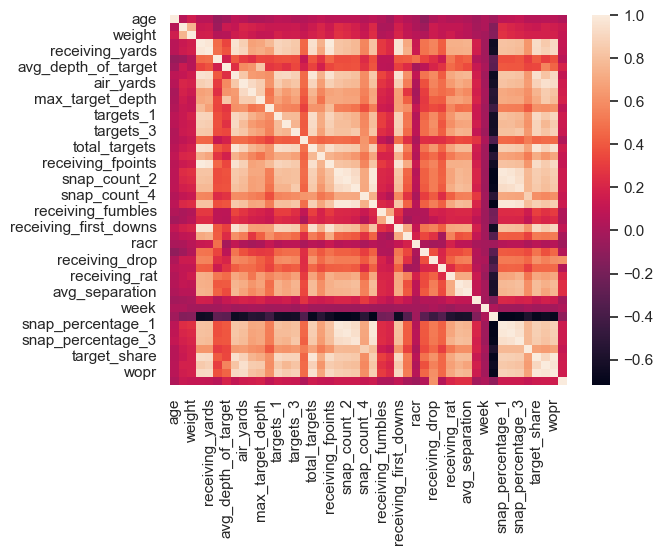

In [103]:
sns.heatmap(pd.DataFrame(X_train_s_all, columns = feature_list).corr())

### Feature Selection

Let's try some feature selection tests.

<Axes: >

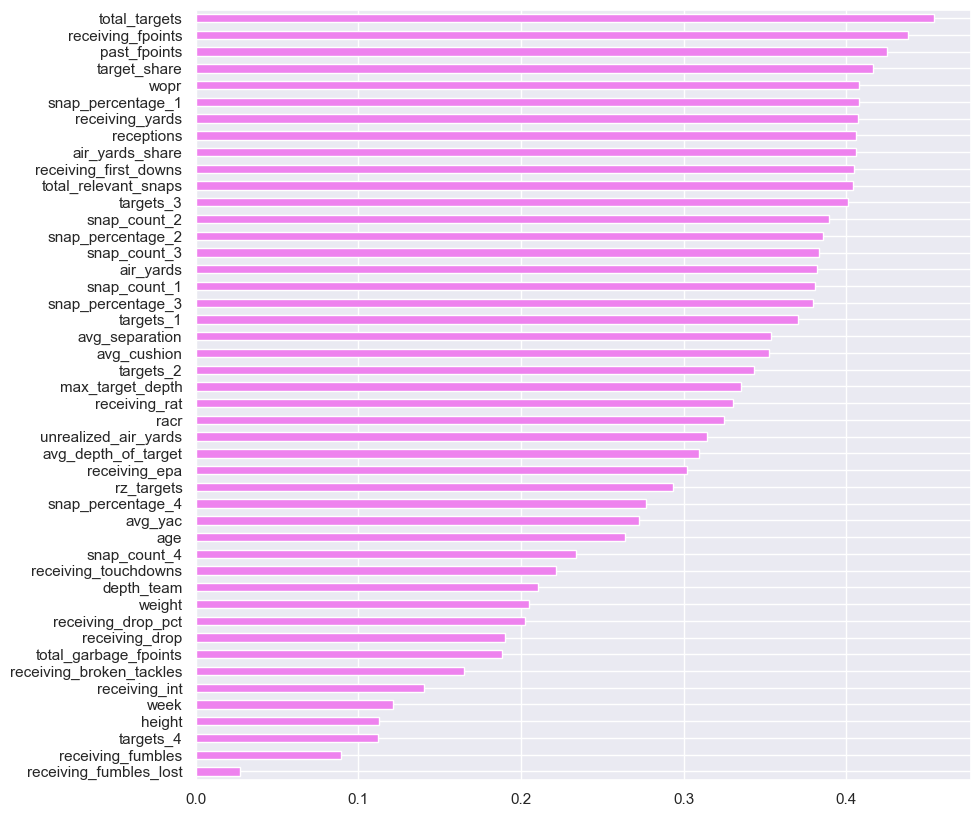

In [104]:
from sklearn.feature_selection import mutual_info_regression, RFE

importances = mutual_info_regression(X_train_s_all, y_train)
feat_importances = pd.Series(importances, feature_list).sort_values(ascending=True)
fig,ax=plt.subplots(figsize=(10,10))
feat_importances.plot(kind='barh', color='violet', ax=ax)

In [105]:
# RFE
estimator = RandomForestRegressor(**params)
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X_train_s_all, y_train)
y_pred = rfe.predict(X_train_s_all)

In [106]:
rfe.ranking_

array([25, 33, 21,  1,  1, 12, 15,  1, 23, 24, 10, 31, 22, 18,  8, 35,  1,
       19,  1,  9,  2, 14, 17, 20, 32, 37,  1, 13, 30, 29, 28, 34,  4,  1,
        1, 36, 27, 11,  1, 16,  6, 26,  1,  3,  5,  7])

In [107]:
r2_score(y_train, y_pred)

0.47290057969803645

In [108]:
# create pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
# https://machinelearningmastery.com/rfe-feature-selection-in-python/


rfe = RFE(estimator=RandomForestRegressor(**params), n_features_to_select=15)
model = RandomForestRegressor(**params)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train_s_all, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -4.182 (0.193)


In [109]:
pipeline.fit(X_train_s_all, y_train)
y_pred_test = pipeline.predict(X_test_s_all)
r2_score(y_pred_test, y_test)

-0.5360973293028464

In [110]:
y_pred_train = pipeline.predict(X_train_s_all)
r2_score(y_pred_train, y_train)

-0.28656545449938253

In [132]:
# get a list of models to evaluate
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
def get_models(rfe):
    models = dict()
    # lr
    model = LinearRegression()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # ridge regression
    model = Ridge()
    models['ridge'] = Pipeline(steps=[('s',rfe),('m',model)])
    # SVM
    model = SVR()
    models['svm'] = Pipeline(steps=[('s',rfe),('m',model)])
    # decision tree
    model = DecisionTreeRegressor()
    models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    model = RandomForestRegressor()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    model = GradientBoostingRegressor()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    return scores

In [133]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=15)
models = get_models(rfe=rfe)
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_s_all, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>lr 0.368 (0.050)
>ridge 0.368 (0.050)
>svm 0.342 (0.048)
>dt -0.237 (0.170)
>rf 0.402 (0.054)
>gbm 0.372 (0.054)


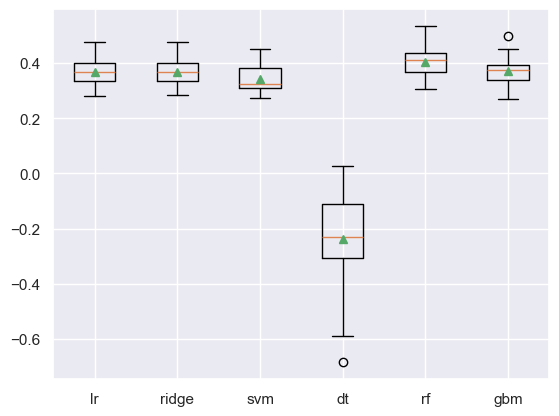

In [134]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [35]:
# random forest is the way to go. let's grab the best feature selection method
# from sklearn.feature_selection import RFECV
def RFE_method_selection(num_features):
    models = dict()
    # lr
    rfe = RFE(LinearRegression(),  n_features_to_select=num_features)
    model = RandomForestRegressor()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # decision tree
    rfe = RFE(DecisionTreeRegressor(),  n_features_to_select=num_features)
    model = RandomForestRegressor()
    models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(RandomForestRegressor(),  n_features_to_select=num_features)
    model = RandomForestRegressor()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(GradientBoostingRegressor(),  n_features_to_select=num_features)
    model = RandomForestRegressor()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models


In [36]:
models = RFE_method_selection(num_features=20)
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_s_all, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>lr 0.472 (0.062)
>dt 0.462 (0.066)
>rf 0.473 (0.073)
>gbm 0.476 (0.071)


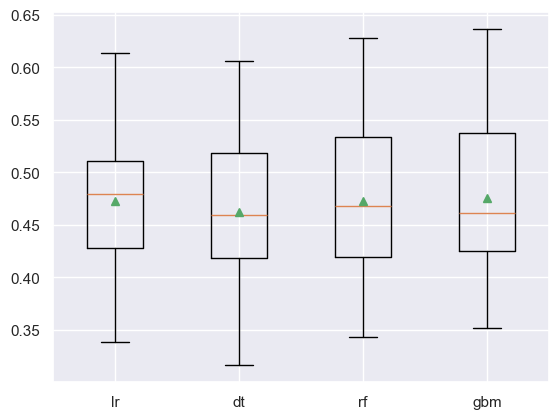

In [37]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [38]:
# linear is the fastest so let's just use that. not much of a difference.,
# random forest is the way to go. let's grab the best feature selection method
# from sklearn.feature_selection import RFECV
def RFE_nfeature_selection():
    models = dict()
    # lr
    rfe = RFE(LinearRegression(),  n_features_to_select=5)
    model = RandomForestRegressor()
    models['n_feat=5'] = Pipeline(steps=[('s',rfe),('m',model)])
    # decision tree
    rfe = RFE(LinearRegression(),  n_features_to_select=15)
    model = RandomForestRegressor()
    models['n_feat=15'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(LinearRegression(),  n_features_to_select=25)
    model = RandomForestRegressor()
    models['n_feat=25'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(LinearRegression(),  n_features_to_select=35)
    model = RandomForestRegressor()
    models['n_feat=35'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

In [39]:
models = RFE_nfeature_selection()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_s_all, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>n_feat=5 0.384 (0.084)
>n_feat=15 0.456 (0.075)
>n_feat=25 0.479 (0.057)
>n_feat=35 0.476 (0.069)


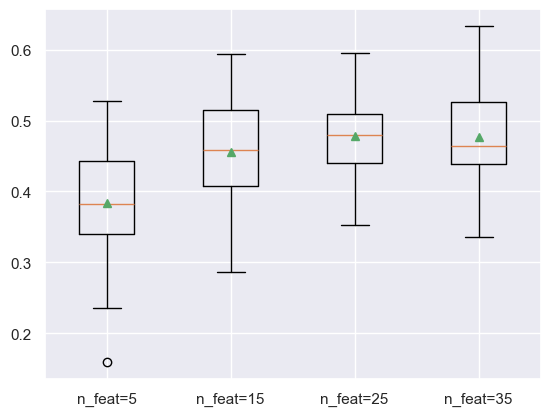

In [40]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [111]:
# looks great! Now we can optimize the RandomForest Regressor with n_features = 25
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
               'm__max_features': max_features,
               'm__max_depth': max_depth,
               'm__min_samples_split': min_samples_split,
               'm__min_samples_leaf': min_samples_leaf,
               'm__bootstrap': bootstrap}
base_estimator = Pipeline(steps=[('s',RFE(LinearRegression(),  n_features_to_select=15)),('m',RandomForestRegressor(random_state=0))])
sh = HalvingGridSearchCV(base_estimator, param_grid = random_grid, cv=5,
                          factor=2, resource='m__n_estimators',
                          max_resources=30).fit(X_train_s_all, y_train)
sh.best_estimator_


Pipeline(steps=[('s',
                 RFE(estimator=LinearRegression(), n_features_to_select=15)),
                ('m',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=10,
                                       n_estimators=16, random_state=0))])

In [112]:
pd.concat([pd.DataFrame(sh.cv_results_["params"]),pd.DataFrame(sh.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values("Accuracy", ascending=False)

,m__bootstrap,m__max_depth,m__max_features,m__min_samples_leaf,m__min_samples_split,m__n_estimators,Accuracy
826,True,10.0,log2,2,10,16,0.416811
825,True,10.0,sqrt,2,10,16,0.416811
824,False,10.0,sqrt,1,5,16,0.412583
823,False,10.0,log2,1,5,16,0.412583
836,False,10.0,log2,2,10,16,0.412380
...,...,...,...,...,...,...,...
54,True,40.0,log2,1,2,1,-0.168207
90,True,60.0,log2,1,2,1,-0.168207
207,True,NaN,sqrt,1,2,1,-0.168207
63,True,40.0,sqrt,1,2,1,-0.168207


In [48]:
rfe = RFE(LinearRegression(),  n_features_to_select=15)
best_model = RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2',
                      min_samples_leaf=2, min_samples_split=5, n_estimators=16,
                      random_state=0)
best_estimator = Pipeline(steps=[('s',rfe),('m',best_model)])
best_estimator.fit(X_train_s_all, y_train)

Pipeline(steps=[('s',
                 RFE(estimator=LinearRegression(), n_features_to_select=15)),
                ('m',
                 RandomForestRegressor(bootstrap=False, max_depth=30,
                                       max_features='log2', min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=16,
                                       random_state=0))])

In [49]:
y_hat = best_estimator.predict(X_test_s_all)
r2_score(y_hat, y_test)

0.11116182097182736

In [50]:
y_hat2 = best_estimator.predict(X_train_s_all)
r2_score(y_hat2, y_train)

0.9505749838798443

In [5]:
# let's try a nueral network before we move on to more feature engineering/regularization. 
# https://www.tensorflow.org/install/pip#windows-wsl2
# https://developer.nvidia.com/rdp/cudnn-download
# https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exe_local
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

2024-01-04 16:50:15.589844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 16:50:15.589917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 16:50:15.590736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 16:50:15.597336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 16:50:16.449622: W tensorflow/compiler/tf2

In [6]:
print(f"Tensorflow Version: {tf.__version__}")
print(f"GPU : {tf.config.list_physical_devices('GPU')}")
print(f"CUDA Test: {tf.test.is_built_with_cuda()}")

Tensorflow Version: 2.15.0
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Test: True


2024-01-04 16:50:18.364526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 16:50:18.392717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 16:50:18.392788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
# uh-oh! Our best model is super overfit. We need to introduce some regularization.